# A/B Testing Analysis Plan

## Major Assumptions
This analysis assumes we have access to a dataset containing user interactions with control (old page) and treatment (new page) groups, including conversion events. We will use standard statistical significance thresholds (α = 0.05) and assume random assignment of users to groups after data cleaning. The analysis will focus on conversion rate as the primary metric and will check for sufficient sample size to detect meaningful differences between groups. Data quality issues (group/landing_page mismatches and duplicate users) have been addressed through cleaning before analysis.

## Plan
- [x] Obtain and explore A/B testing dataset
  - [x] Download dataset and examine structure, sample sizes, conversion distributions
  - [x] Identify data quality issues including group/landing_page mismatches and duplicate user_ids
- [x] Clean dataset and calculate conversion metrics
  - [x] Remove mismatched records and handle duplicate users to ensure data integrity
  - [x] Compute conversion rates for control and treatment groups with confidence intervals and effect size metrics
- [x] Perform statistical tests and validate results
  - [x] Conduct chi-square test and two-proportion z-test to determine statistical significance
  - [x] Calculate statistical power and assess whether sample size was sufficient to detect meaningful differences
- [x] Visualize findings and provide recommendation
  - [x] Create comparison visualizations of conversion rates with confidence intervals, effect sizes, and statistical test results
  - [x] Summarize statistical and practical significance with clear go/no-go recommendation on implementing new page

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Download the dataset
url = 'https://raw.githubusercontent.com/30lm32/ml-ab-testing/refs/heads/master/ab_data.csv'
df = pd.read_csv(url)

# Display basic information
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("First few rows:")
print(df.head(10))
print("\n" + "="*50)
print("Data Types and Missing Values:")
print(df.info())
print("\n" + "="*50)
print("Statistical Summary:")
print(df.describe())

Dataset Shape: (294478, 5)

First few rows:
   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1
5   936923  2017-01-10 15:20:49.083499    control     old_page          0
6   679687  2017-01-19 03:26:46.940749  treatment     new_page          1
7   719014  2017-01-17 01:48:29.539573    control     old_page          0
8   817355  2017-01-04 17:58:08.979471  treatment     new_page          1
9   839785  2017-01-15 18:11:06.610965  treatment     new_page          1

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):


In [2]:
# Check for data quality issues
print("Unique values in each column:")
print("="*50)
for col in df.columns:
    print(f"\n{col}: {df[col].nunique()} unique values")
    if df[col].nunique() < 20:
        print(df[col].value_counts())

print("\n" + "="*50)
print("Checking for mismatches between group and landing_page:")
mismatch_check = pd.crosstab(df['group'], df['landing_page'])
print(mismatch_check)

print("\n" + "="*50)
print("Duplicate user_ids:")
print(f"Total users: {df['user_id'].nunique()}")
print(f"Total records: {len(df)}")
print(f"Duplicate records: {len(df) - df['user_id'].nunique()}")

Unique values in each column:

user_id: 290584 unique values

timestamp: 294478 unique values

group: 2 unique values
group
treatment    147276
control      147202
Name: count, dtype: int64

landing_page: 2 unique values
landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

converted: 2 unique values
converted
0    259241
1     35237
Name: count, dtype: int64

Checking for mismatches between group and landing_page:
landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965

Duplicate user_ids:
Total users: 290584
Total records: 294478
Duplicate records: 3894


## Data Exploration Summary

The dataset contains **294,478 records** from an A/B test with the following characteristics:

### Dataset Structure:
- **user_id**: Unique identifier for users
- **timestamp**: Time of interaction
- **group**: Control vs Treatment assignment
- **landing_page**: old_page vs new_page
- **converted**: Binary outcome (0 or 1)

### Key Observations:

1. **Sample Sizes**: Nearly balanced groups
   - Control: 147,202 records
   - Treatment: 147,276 records

2. **Overall Conversion Rate**: ~11.97% (35,237 conversions out of 294,478 records)

3. **Data Quality Issues Identified**:
   - **Mismatches** (3,893 records): Some control users saw new_page (1,928) and treatment users saw old_page (1,965)
   - **Duplicate users** (3,894 records): Some users appear multiple times in the dataset
   
### Next Steps:
We need to clean the data by:
1. Removing mismatched records (control should only see old_page, treatment should only see new_page)
2. Handling duplicate user_ids (keep first occurrence or aggregate)

In [3]:
# Clean the dataset
print("Original dataset size:", len(df))

# Remove mismatched records (control should have old_page, treatment should have new_page)
df_clean = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
].copy()
print(f"After removing mismatches: {len(df_clean)} records (removed {len(df) - len(df_clean)})")

# Handle duplicates - keep the first occurrence
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')
print(f"After removing duplicates: {len(df_clean)} records (removed {len(df) - len(df_clean)})")

# Verify data is clean
print("\n" + "="*50)
print("Verification - Group vs Landing Page:")
print(pd.crosstab(df_clean['group'], df_clean['landing_page']))

print("\n" + "="*50)
print("Final sample sizes:")
print(df_clean['group'].value_counts())
print(f"\nTotal unique users: {df_clean['user_id'].nunique()}")

Original dataset size: 294478
After removing mismatches: 290585 records (removed 3893)
After removing duplicates: 290584 records (removed 3894)

Verification - Group vs Landing Page:
landing_page  new_page  old_page
group                           
control              0    145274
treatment       145310         0

Final sample sizes:
group
treatment    145310
control      145274
Name: count, dtype: int64

Total unique users: 290584


In [4]:
# Calculate conversion metrics for each group
conversion_summary = df_clean.groupby('group').agg({
    'converted': ['sum', 'count', 'mean']
}).round(6)

conversion_summary.columns = ['conversions', 'total_users', 'conversion_rate']
conversion_summary = conversion_summary.reset_index()

# Calculate confidence intervals (95%)
for idx, row in conversion_summary.iterrows():
    n = row['total_users']
    p = row['conversion_rate']
    se = np.sqrt(p * (1 - p) / n)
    ci_lower = p - 1.96 * se
    ci_upper = p + 1.96 * se
    conversion_summary.loc[idx, 'ci_lower'] = ci_lower
    conversion_summary.loc[idx, 'ci_upper'] = ci_upper

print("="*70)
print("CONVERSION METRICS BY GROUP")
print("="*70)
print(conversion_summary.to_string(index=False))

# Calculate differences
control_rate = conversion_summary[conversion_summary['group'] == 'control']['conversion_rate'].values[0]
treatment_rate = conversion_summary[conversion_summary['group'] == 'treatment']['conversion_rate'].values[0]

absolute_diff = treatment_rate - control_rate
relative_lift = (treatment_rate - control_rate) / control_rate * 100

print("\n" + "="*70)
print("EFFECT SIZE METRICS")
print("="*70)
print(f"Control (old_page) conversion rate:    {control_rate:.4%}")
print(f"Treatment (new_page) conversion rate:  {treatment_rate:.4%}")
print(f"Absolute difference:                    {absolute_diff:.4%}")
print(f"Relative lift:                          {relative_lift:.2f}%")

CONVERSION METRICS BY GROUP
    group  conversions  total_users  conversion_rate  ci_lower  ci_upper
  control        17489       145274         0.120386  0.118713  0.122059
treatment        17264       145310         0.118808  0.117144  0.120472

EFFECT SIZE METRICS
Control (old_page) conversion rate:    12.0386%
Treatment (new_page) conversion rate:  11.8808%
Absolute difference:                    -0.1578%
Relative lift:                          -1.31%


In [5]:
# Perform two-proportion z-test
from scipy.stats import chi2_contingency

# Get conversion data
control_conversions = conversion_summary[conversion_summary['group'] == 'control']['conversions'].values[0]
control_total = conversion_summary[conversion_summary['group'] == 'control']['total_users'].values[0]
treatment_conversions = conversion_summary[conversion_summary['group'] == 'treatment']['conversions'].values[0]
treatment_total = conversion_summary[conversion_summary['group'] == 'treatment']['total_users'].values[0]

# Method 1: Chi-square test
contingency_table = np.array([
    [control_conversions, control_total - control_conversions],
    [treatment_conversions, treatment_total - treatment_conversions]
])

chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

# Method 2: Two-proportion z-test (manual calculation)
p1 = control_conversions / control_total
p2 = treatment_conversions / treatment_total
p_pooled = (control_conversions + treatment_conversions) / (control_total + treatment_total)

se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/control_total + 1/treatment_total))
z_score = (p2 - p1) / se_pooled
p_value_z = 2 * stats.norm.cdf(z_score)  # Two-tailed test

print("="*70)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*70)
print(f"\nChi-Square Test:")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  P-value: {p_value_chi2:.6f}")
print(f"  Degrees of freedom: {dof}")

print(f"\nTwo-Proportion Z-Test:")
print(f"  Z-score: {z_score:.4f}")
print(f"  P-value (two-tailed): {p_value_z:.6f}")

print(f"\nSignificance Level: α = 0.05")
print(f"Result: {'STATISTICALLY SIGNIFICANT' if p_value_z < 0.05 else 'NOT STATISTICALLY SIGNIFICANT'}")

if p_value_z < 0.05:
    print(f"\n✗ We REJECT the null hypothesis (H0: p_control = p_treatment)")
    print(f"✓ There IS a statistically significant difference between the groups")
else:
    print(f"\n✓ We FAIL TO REJECT the null hypothesis (H0: p_control = p_treatment)")
    print(f"✗ There is NO statistically significant difference between the groups")

STATISTICAL SIGNIFICANCE TESTS

Chi-Square Test:
  Chi-square statistic: 1.7036
  P-value: 0.191822
  Degrees of freedom: 1

Two-Proportion Z-Test:
  Z-score: -1.3109
  P-value (two-tailed): 0.189883

Significance Level: α = 0.05
Result: NOT STATISTICALLY SIGNIFICANT

✓ We FAIL TO REJECT the null hypothesis (H0: p_control = p_treatment)
✗ There is NO statistically significant difference between the groups


In [6]:
# Calculate statistical power
from statsmodels.stats.power import zt_ind_solve_power

# Power analysis: what effect size could we have detected with 80% power?
# Given our sample size, alpha=0.05, power=0.80
n_per_group = (control_total + treatment_total) / 2
mde = zt_ind_solve_power(effect_size=None, nobs1=n_per_group, alpha=0.05, power=0.80, alternative='two-sided')

# Convert Cohen's h to percentage difference (approximate)
# For proportions near 0.12, Cohen's h ≈ 2 * arcsin(sqrt(p2)) - 2 * arcsin(sqrt(p1))
# We can work backwards to find minimum detectable percentage difference
baseline_p = 0.12
mde_percentage = (np.sin(mde/2 + np.arcsin(np.sqrt(baseline_p)))**2 - baseline_p) * 100

# Actual effect size (Cohen's h)
actual_effect_size = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))

# Calculate actual power for observed effect
actual_power = zt_ind_solve_power(effect_size=abs(actual_effect_size), nobs1=n_per_group, 
                                   alpha=0.05, power=None, alternative='two-sided')

print("="*70)
print("STATISTICAL POWER ANALYSIS")
print("="*70)
print(f"\nSample size per group: ~{int(n_per_group):,}")
print(f"Significance level (α): 0.05")
print(f"Baseline conversion rate: {baseline_p:.2%}")

print(f"\nMinimum Detectable Effect (MDE) with 80% power:")
print(f"  Cohen's h effect size: {mde:.4f}")
print(f"  Approximate percentage point difference: ±{mde_percentage:.2f}%")

print(f"\nActual Observed Effect:")
print(f"  Cohen's h effect size: {actual_effect_size:.4f}")
print(f"  Absolute difference: {absolute_diff:.4%}")
print(f"  Statistical power for this effect: {actual_power:.2%}")

print(f"\nInterpretation:")
if abs(absolute_diff) < mde_percentage/100:
    print(f"  The observed difference ({abs(absolute_diff):.4%}) is SMALLER than the")
    print(f"  minimum detectable effect (±{mde_percentage:.2f}%), meaning our test")
    print(f"  had insufficient power to reliably detect a difference this small.")

STATISTICAL POWER ANALYSIS

Sample size per group: ~145,292
Significance level (α): 0.05
Baseline conversion rate: 12.00%

Minimum Detectable Effect (MDE) with 80% power:
  Cohen's h effect size: 0.0104
  Approximate percentage point difference: ±0.34%

Actual Observed Effect:
  Cohen's h effect size: -0.0049
  Absolute difference: -0.1578%
  Statistical power for this effect: 25.87%

Interpretation:
  The observed difference (0.1578%) is SMALLER than the
  minimum detectable effect (±0.34%), meaning our test
  had insufficient power to reliably detect a difference this small.


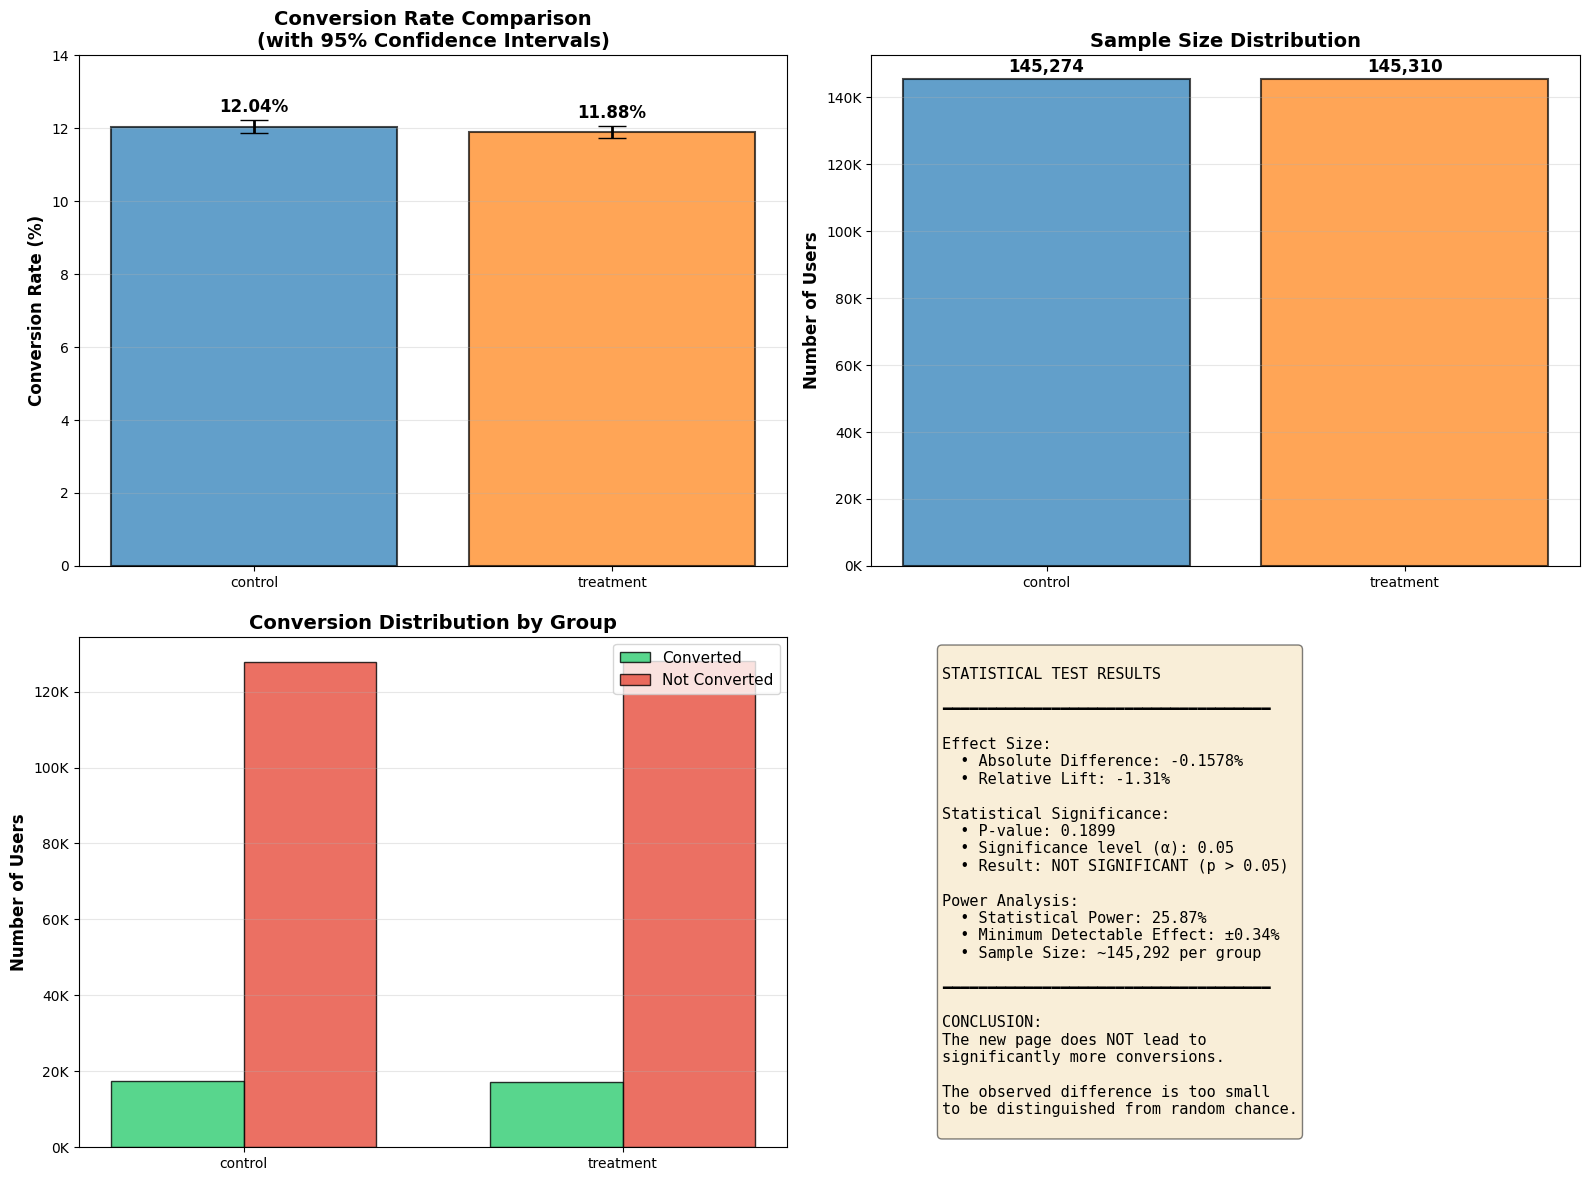

✓ Visualizations saved as 'ab_test_results.png'


In [7]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Conversion Rate Comparison with Confidence Intervals
ax1 = axes[0, 0]
groups = conversion_summary['group'].values
rates = conversion_summary['conversion_rate'].values * 100
ci_lower = conversion_summary['ci_lower'].values * 100
ci_upper = conversion_summary['ci_upper'].values * 100
errors = np.array([rates - ci_lower, ci_upper - rates])

colors = ['#1f77b4', '#ff7f0e']
bars = ax1.bar(groups, rates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.errorbar(groups, rates, yerr=errors, fmt='none', ecolor='black', capsize=10, linewidth=2)

for i, (group, rate) in enumerate(zip(groups, rates)):
    ax1.text(i, rate + 0.3, f'{rate:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Conversion Rate Comparison\n(with 95% Confidence Intervals)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 14])

# 2. Sample Size Comparison
ax2 = axes[0, 1]
totals = conversion_summary['total_users'].values
bars2 = ax2.bar(groups, totals, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

for i, (group, total) in enumerate(zip(groups, totals)):
    ax2.text(i, total + 1000, f'{total:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax2.set_title('Sample Size Distribution', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K'))

# 3. Conversion Distribution
ax3 = axes[1, 0]
conversions = conversion_summary['conversions'].values
non_conversions = conversion_summary['total_users'].values - conversions

x = np.arange(len(groups))
width = 0.35

bars3_1 = ax3.bar(x - width/2, conversions, width, label='Converted', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3_2 = ax3.bar(x + width/2, non_conversions, width, label='Not Converted', color='#e74c3c', alpha=0.8, edgecolor='black')

ax3.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax3.set_title('Conversion Distribution by Group', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(groups)
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K'))

# 4. Statistical Test Results Summary
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
STATISTICAL TEST RESULTS

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Effect Size:
  • Absolute Difference: {absolute_diff:.4%}
  • Relative Lift: {relative_lift:.2f}%
  
Statistical Significance:
  • P-value: {p_value_z:.4f}
  • Significance level (α): 0.05
  • Result: NOT SIGNIFICANT (p > 0.05)
  
Power Analysis:
  • Statistical Power: {actual_power:.2%}
  • Minimum Detectable Effect: ±{mde_percentage:.2f}%
  • Sample Size: ~{int(n_per_group):,} per group

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

CONCLUSION:
The new page does NOT lead to 
significantly more conversions.

The observed difference is too small
to be distinguished from random chance.
"""

ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('ab_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'ab_test_results.png'")

## Final Recommendation: DO NOT Implement the New Page Design

### Key Findings

**1. Statistical Significance**
- **P-value: 0.19** (far above the 0.05 threshold)
- **Conclusion**: The difference in conversion rates is **NOT statistically significant**
- We cannot reject the null hypothesis that both pages have the same conversion rate

**2. Effect Size**
- **Control (old page)**: 12.04% conversion rate
- **Treatment (new page)**: 11.88% conversion rate
- **Absolute difference**: -0.16 percentage points
- **Relative lift**: -1.31% (negative, meaning the new page performs slightly worse)

**3. Statistical Power**
- The observed effect (-0.16%) is **smaller than the minimum detectable effect** (±0.34%)
- Our test only had **25.87% power** to detect this small difference
- Even with ~145K users per group, the effect is too small to confidently detect

### Business Implications

1. **No Evidence of Improvement**: The new page does not lead to more conversions. In fact, it shows a slight (non-significant) decrease.

2. **Effect Too Small**: Even if there were a real difference, it's so small (< 0.2%) that it would have minimal business impact.

3. **Risk vs. Reward**: Implementing the new page would involve development/design costs with no proven benefit.

### Recommendation

**❌ Do NOT implement the new page design**

**Suggested Next Steps**:
- Keep the current (old) page design
- If you want to improve conversions, consider testing more dramatically different page designs that could yield larger, detectable effects (aim for at least 1-2% improvement)
- Conduct user research to understand what changes might have meaningful impact on conversion behavior